In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from glob import glob
from pysolar.solar import get_altitude, radiation

from clearml import Task
from clearml import Dataset

from sklearn import linear_model

In [2]:
# Constants 
BUILDING_LAT = 39.9649 
BUILDING_LON = -75.1396 

In [3]:
# ClearML Stuff
task = Task.init(project_name="amplify", task_name="power-ss-notebook")

building_data_dir = glob(
    Dataset.get(
        dataset_project="amplify", 
        dataset_name="building_data"
    ).get_local_copy()
    + "/**"
)[0]

weather_data_dir = glob(
    Dataset.get(
        dataset_project="amplify", 
        dataset_name="weather_data"
    ).get_local_copy()
    + "/**"
)[0]


In [4]:
# Building Data

# Read csv w/out header
building_data = pd.read_csv(building_data_dir, header=None, low_memory=False)

# Uncomment the following line to retrieve data from the local store
building_data = pd.read_csv('../data/2021-10-19_2022-01-09_CF2.csv', header=None, low_memory=False)

keep_columns = [
    "True Power (kW)",
    "Total Energy (kWh)",
    "Reactive Energy (kVARh)",
    "Reactive Power (kVAR)",
    "Apparent Power (kVA)",
    "Apparent Energy (kVAh)",
    "dPF",
    "aPF",
    "Current (A)"
]

# Forward fill the header name for each PowerScout
building_data.iloc[0] = building_data.T[0].fillna(method="ffill")

# Rename the 'nan' block
building_data.loc[0, 0] = "Timestamp"

# Create the multi-index
building_data.columns = [list(building_data.iloc[0]), list(building_data.iloc[1])]

# Drop the first two rows because they're just the column names, and any column with only nulls
building_data = building_data[2:]

# Convert timestamp column to datetime format 
building_data.Timestamp = pd.to_datetime(
    building_data.Timestamp.Timestamp, 
    infer_datetime_format=True,
)

# Set Timestamp column as index, set columns to type 'float', rename index
building_data = (
    building_data.set_index([("Timestamp", "Timestamp")])
    .replace("-", np.nan)
    .astype(float)
)
building_data.index.rename("Timestamp", inplace=True)

# Set building_data to Eastern timezone and then convert to UTC
building_data = building_data.tz_localize('America/New_York', ambiguous=True).tz_convert('UTC')

# deduplicate index
building_data = building_data.drop_duplicates(keep='last')

# Drop any column or row with all nulls
building_data = building_data.dropna(how="all", axis=1).dropna(how="all", axis=0)

# remove noise (zeros) from the building_data
building_data = building_data.replace(0, np.nan).fillna(method="ffill")

# Slice to the two power systems we're monitoring and rename columns
building_data = building_data[["PowerScout DPS126", "PowerScout DPS121"]].rename(
    columns={"PowerScout DPS126": "solar", "PowerScout DPS121": "usage"}
)

# Create our separate y-columns: solar pwr generated, buildling pwr used
idx = pd.IndexSlice

# Create DF with only Energy - keep just the last value (meter readings)
building_data = building_data.loc[idx[:], idx[:, keep_columns]]

# Set some relevant datetimes based on building power data timeframe
end_date = dt.datetime.today()
start_date = building_data.index[-1]

In [5]:
# Weather Data

# Read csv w/out header
weather_data = pd.read_csv(weather_data_dir, header=0, low_memory=False)

# Uncomment the following line to retrieve data from the local store
# weather_data = pd.read_csv("../data/CF2_Weather_2020-2022.csv")

#TODO clip weather data to start and end on same dates as building data

## Clean up datetime, drop 2nd datetime column
# Convert from POSIX to ISO UTC time
weather_data.dt = pd.to_datetime(weather_data.dt, unit='s', utc=True, infer_datetime_format=True)

# Set date as index
weather_data = weather_data.set_index('dt')

# Drop 2nd datetime column that's not needed
weather_data = weather_data[['temp', 'pressure', 'humidity', 'clouds_all']]

# Add Solar Irradiance
weather_data['irradiance'] = np.nan
date_list = list(weather_data.index)
for date in date_list:
    altitude_deg = get_altitude(BUILDING_LAT, BUILDING_LON, date.to_pydatetime())
    weather_data.loc[date, 'irridance'] = radiation.get_radiation_direct(date.to_pydatetime(), altitude_deg)
    
# Trim weather data to match building data timeframe:
weather_data = weather_data[(weather_data.index >= building_data.index[-1])
                             & (weather_data.index <= building_data.index[0])
                             ]

# Fill nulls in irradiance with 0
weather_data = weather_data.replace(np.nan, 0)

# deduplicate index
weather_data = weather_data.drop_duplicates()

## Match weather_data index to building_data index timestamps, and ffill missing weather data
# Add new index locations for the missing timestamps
weather_data = weather_data.append(pd.DataFrame(set(building_data.index) 
                                                - set(weather_data.index)).set_index(0)
                                  )

# Embed the added index timestamps into the correct time
weather_data = weather_data.reset_index().sort_values('index').set_index('index')

# Forward fill the weather_data
weather_data = weather_data.fillna(method='ffill')

/opt/tljh/user/lib/python3.9/site-packages/pysolar/radiation.py:50: RuntimeWarning: overflow encountered in exp
  return flux * math.exp(-1 * optical_depth * air_mass_ratio) * is_daytime
/opt/tljh/user/lib/python3.9/site-packages/pysolar/radiation.py:50: RuntimeWarning: invalid value encountered in multiply
  return flux * math.exp(-1 * optical_depth * air_mass_ratio) * is_daytime


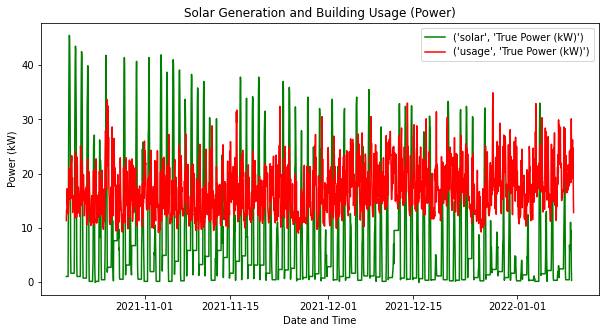

In [6]:
# Plot Power - Solar Gen vs Building Usage
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Solar Generation and Building Usage (Power)')

ax.plot(building_data.solar['True Power (kW)'], color='g')
ax.plot(building_data.usage['True Power (kW)'], color='r')

ax.set_xlabel('Date and Time')
ax.set_ylabel('Power (kW)')
plt.legend(building_data.columns)
plt.show()

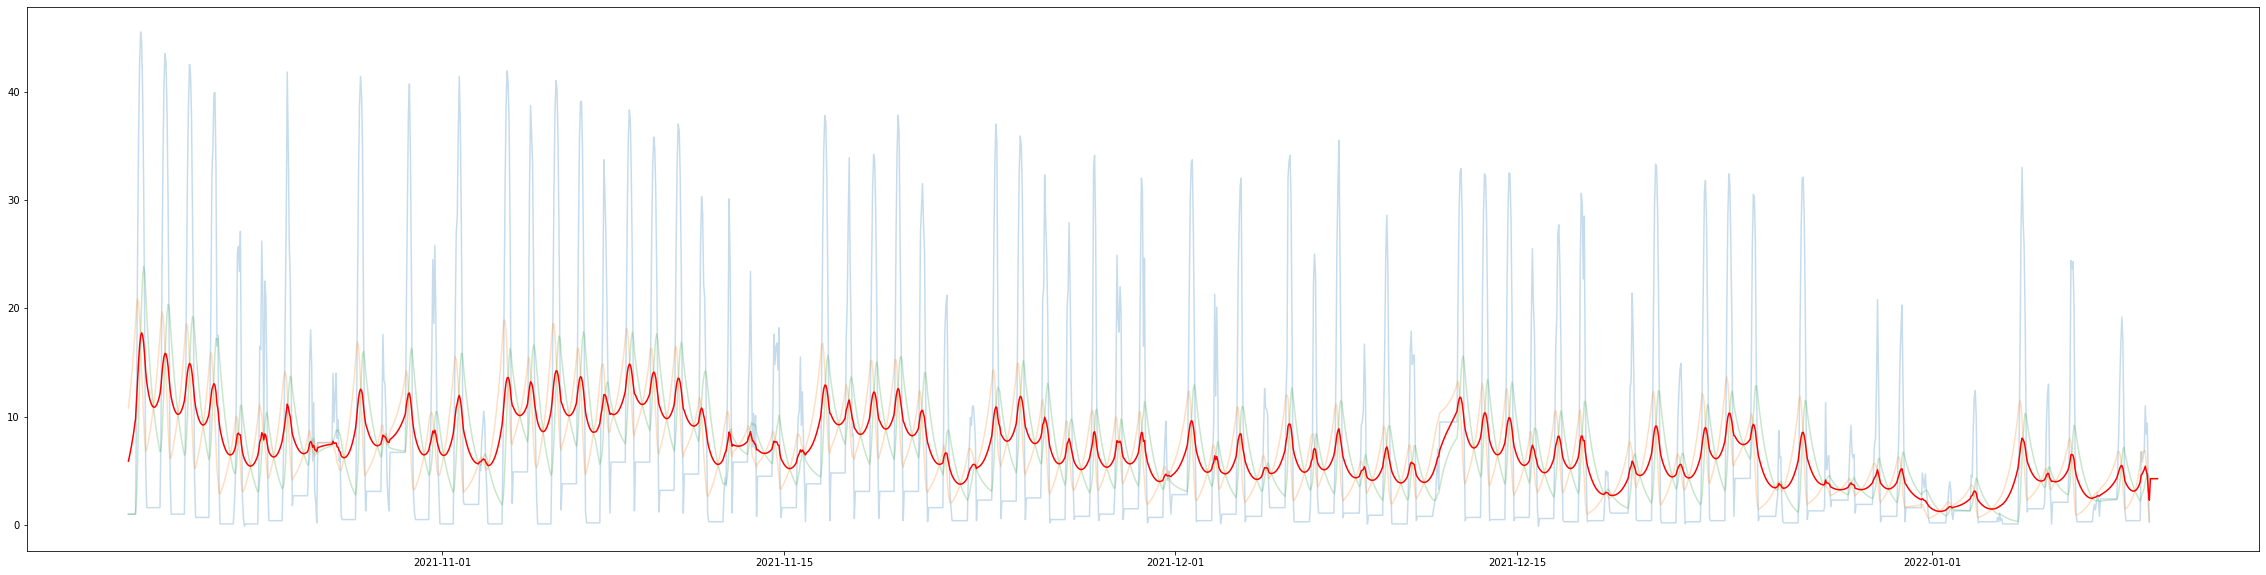

In [7]:
# Reversed-Recombined EWMA for improved accuracy
ewm = pd.DataFrame()                                                               # To collect data
ewm['fwd'] = building_data.solar['True Power (kW)'].ewm(span=24).mean()            # Calc forward EWMA
ewm['bwd'] = building_data.solar['True Power (kW)'][::-1].ewm(span=24).mean()      # Calc reversed EWMA

ewm['combo'] = ewm.mean(axis=1)                                                    # Reversed-Recombined EWMA

# Plotting
plt.figure(figsize=(40, 10))
plt.plot(building_data.solar['True Power (kW)'], alpha=0.25)
plt.plot(ewm.fwd, alpha=0.25)
plt.plot(ewm.bwd, alpha=0.25)
plt.plot(ewm.combo, color='r')

plt.show()

In [8]:
# Set date to split train/test at
split_date = pd.to_datetime('2022-01-01', utc=True)

# Test / Train split based on chosen split_date
weather_train = weather_data[weather_data.index <= split_date]
ewm_train = ewm[ewm.index <= split_date]

weather_test = weather_data[(weather_data.index > split_date)]
ewm_test = ewm[ewm.index > split_date]

# On to the regression:
clf = linear_model.LinearRegression()
clf.fit(weather_train, ewm_train)

print(clf.coef_)

weather_pred = clf.predict(weather_test)

ValueError: Found input variables with inconsistent numbers of samples: [1773, 1772]